In [35]:
import numpy as np
import pandas as pd
import SolveLinSys
import matplotlib.pyplot as plt
from numba import njit

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
from derivative import derivatives_2d
from scipy.interpolate import interp2d

In [36]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / (2 * dlt)) * (data[2:,:] - data[:-2,:])
            res[-1,:] = (1 / dlt) * (data[-1,:] - data[-2,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / (2 * dlt)) * (data[:,2:] - data[:,:-2])
            res[:,-1] = (1 / dlt) * (data[:,-1] - data[:,-2])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

PDE:
\begin{align*}
0 = \max_{\mathcal{E}}  &  -\delta \phi(y_1, y_2) + \delta \eta \log \mathcal{E} \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} (-\lambda y_2 + \lambda \theta \mathcal{E})\\
&+ (\eta-1)\left[\gamma_1 + \gamma_2 y_1 + \gamma_2^+\boldsymbol{1}_{y_1\geq \bar{y}_1}(y_1-\bar{y}_1)\right]y_2\\
\end{align*}

FOC of $\mathcal{E}$ gives:
$$
\mathcal{E} = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

In [128]:
def false_transient(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, γ_2p, y_bar = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -δ*η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat + γ_2p*(y1_mat>y_bar)*(y1_mat-y_bar)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

#         v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
#         v0_dy2 = compute_derivatives(v0, 1, 1, dy2)
        v0_dy1 = derivatives_2d(v0, 0, 1, dy1)
        v0_dy2 = derivatives_2d(v0, 1, 1, dy2)        

        e_tilde = -δ*η/(v0_dy2*λ*θ)
        e_tilde[e_tilde<=0] = 1e-15

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
#         B2 = λ*(-y2_mat+θ*e_tilde)
        B2 = λ*(-y2_mat)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
#         D = δ*η*np.log(e_tilde) + (η-1)*d_Λ*y2_mat
        D = δ*η*np.log(e_tilde) + (η-1)*d_Λ*y2_mat - δ*η

        res = false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
#         print(np.max(v0))
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [149]:
λ = .116 # half life = 6 years 

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
θ = np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = .0197*2*.5 # weighted model of low and high
γ_2p = 0.

n_y1 = 50
y1_min = 0.
y1_max = 4.
y1_grid = np.linspace(y1_min, y1_max, n_y1)

n_y2 = 50
y2_min = 0.
y2_max = 1.
y2_grid = np.linspace(y2_min, y2_max, n_y2)

model_paras = (η, δ, θ, γ_1, γ_2, γ_2p, y_bar)
model_res = false_transient(y1_grid, y2_grid, model_paras,
                            v0=None, ϵ=1., tol=1e-7, max_iter=360, print_all=True)

0.0023509207547005397
Iteration 1: LHS Error: 0.01930411816234095; RHS Error 0.01839100533560723
0.0042329051201128905
Iteration 2: LHS Error: 0.020024106686740168; RHS Error 0.019766930216052355
0.005836134453485745
Iteration 3: LHS Error: 0.019823096963474313; RHS Error 0.020038944645713142
0.007261388987783098
Iteration 4: LHS Error: 0.019211927022466255; RHS Error 0.019761181423013897
0.00855878009550248
Iteration 5: LHS Error: 0.01834505479367693; RHS Error 0.019120853485738727
0.00975740440624175
Iteration 6: LHS Error: 0.017321020218167532; RHS Error 0.018242106459857084
0.01087609827075082
Iteration 7: LHS Error: 0.016209425786659182; RHS Error 0.017214562084048188
0.011928009106725639
Iteration 8: LHS Error: 0.015060474298450977; RHS Error 0.016104043837816752
0.012922823191443803
Iteration 9: LHS Error: 0.013910273025929593; RHS Error 0.01495880913559229
0.013867969201563702
Iteration 10: LHS Error: 0.012784394636294633; RHS Error 0.013813841922951577
0.01476932204107576
Iter

0.04499028668850434
Iteration 85: LHS Error: 0.00021091842590932608; RHS Error 0.00021091842899107426
0.04519836881607451
Iteration 86: LHS Error: 0.00020808212757016803; RHS Error 0.00020808213061929392
0.04540366073024692
Iteration 87: LHS Error: 0.00020529191417240772; RHS Error 0.00020529191720011785
0.04560620750215541
Iteration 88: LHS Error: 0.00020254677190849335; RHS Error 0.00020254677491352848
0.04580605322324869
Iteration 89: LHS Error: 0.00019984572109327942; RHS Error 0.00019984572407015017
0.04600324103767295
Iteration 90: LHS Error: 0.00019718781442425865; RHS Error 0.00019718781737544313
0.04619781317307599
Iteration 91: LHS Error: 0.00019457213540303997; RHS Error 0.00019457213831533093
0.04638981096979285
Iteration 92: LHS Error: 0.00019199779671685846; RHS Error 0.00019199779961732142
0.04657927490880303
Iteration 93: LHS Error: 0.00018946393901018294; RHS Error 0.00018946394187161609
0.046766244640755586
Iteration 94: LHS Error: 0.00018696973195255623; RHS Error 0.

0.056329906506183386
Iteration 177: LHS Error: 6.757290114116354e-05; RHS Error 6.757289721440836e-05
0.056396708394523
Iteration 178: LHS Error: 6.680188833961542e-05; RHS Error 6.680188688817869e-05
0.05646274893238075
Iteration 179: LHS Error: 6.604053785774777e-05; RHS Error 6.604053402190283e-05
0.056528037616394335
Iteration 180: LHS Error: 6.528868401358551e-05; RHS Error 6.528868027868033e-05
0.056592583791200454
Iteration 181: LHS Error: 6.454617480611963e-05; RHS Error 6.454617107006378e-05
0.056656396648784434
Iteration 182: LHS Error: 6.381285758397942e-05; RHS Error 6.381285388590849e-05
0.05671948523126604
Iteration 183: LHS Error: 6.308858248160742e-05; RHS Error 6.308857888689034e-05
0.05678185843375721
Iteration 184: LHS Error: 6.237320249116718e-05; RHS Error 6.237319890575526e-05
0.056843525006705545
Iteration 185: LHS Error: 6.16665729483365e-05; RHS Error 6.166656942833981e-05
0.05690449355898111
Iteration 186: LHS Error: 6.096855227556708e-05; RHS Error 6.09685487

0.0599981003736638
Iteration 262: LHS Error: 2.591237081944059e-05; RHS Error 2.5912372557256426e-05
0.060023724361019534
Iteration 263: LHS Error: 2.562398735573429e-05; RHS Error 2.5623989303921128e-05
0.06004906322787046
Iteration 264: LHS Error: 2.5338866850924124e-05; RHS Error 2.533886862209696e-05
0.06007412019721111
Iteration 265: LHS Error: 2.505696934065188e-05; RHS Error 2.505697285276056e-05
0.06009889845917074
Iteration 266: LHS Error: 2.4778261959630676e-05; RHS Error 2.4778265364293946e-05
0.060123401165931685
Iteration 267: LHS Error: 2.450270676094407e-05; RHS Error 2.4502708874233324e-05
0.0601476314307899
Iteration 268: LHS Error: 2.4230264858211836e-05; RHS Error 2.4230266727942552e-05
0.0601715923308086
Iteration 269: LHS Error: 2.396090001870188e-05; RHS Error 2.3960903341140017e-05
0.06019528691123677
Iteration 270: LHS Error: 2.369458042816852e-05; RHS Error 2.36945836852928e-05
0.06021871818038239
Iteration 271: LHS Error: 2.3431269145619826e-05; RHS Error 2.34

0.06146259757821131
Iteration 352: LHS Error: 9.538138089536241e-06; RHS Error 9.538137389802676e-06
0.061472031188332305
Iteration 353: LHS Error: 9.433610120991587e-06; RHS Error 9.433607986241745e-06
0.061481361429538736
Iteration 354: LHS Error: 9.330241206431666e-06; RHS Error 9.330240165144167e-06
0.0614905894506481
Iteration 355: LHS Error: 9.22802110936427e-06; RHS Error 9.228022715247015e-06
0.061499716394004374
Iteration 356: LHS Error: 9.126943356273232e-06; RHS Error 9.126942286636014e-06
0.06150874337684708
Iteration 357: LHS Error: 9.026982842705311e-06; RHS Error 9.026984539550883e-06
0.06151767151602656
Iteration 358: LHS Error: 8.928139179478767e-06; RHS Error 8.928138396927551e-06
0.061526501904286046
Iteration 359: LHS Error: 8.830388259488398e-06; RHS Error 8.830389914109499e-06
0.06153523563074828
Iteration 360: LHS Error: 8.73372646223447e-06; RHS Error 8.73372804889366e-06
Converged. Total iteration 360: LHS Error: 8.73372646223447e-06; RHS Error 8.73372804889366

In [150]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = y2_0 - λ*y2_0 + λ*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [151]:
# et, y1t, y2t = simulation(y1_grid, y2_grid, model_res['e_tilde'], λ,
#                           θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100)

et, y1t, y2t = simulation(y1_grid, y2_grid, e_tilde_check, λ,
                          θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100)

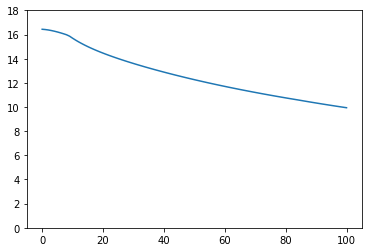

In [152]:
plt.plot(et)
plt.ylim(0, 18)
np.save('et_two_state.npy', et)

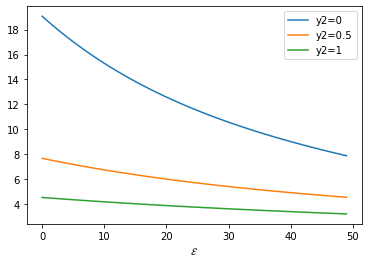

In [114]:
plt.plot(model_res['e_tilde'][:, 0], label='y2=0')
plt.plot(model_res['e_tilde'][:, 25], label='y2=0.5')
plt.plot(model_res['e_tilde'][:, -1], label='y2=1')
plt.xlabel(r'$\mathcal{E}$')
plt.legend()

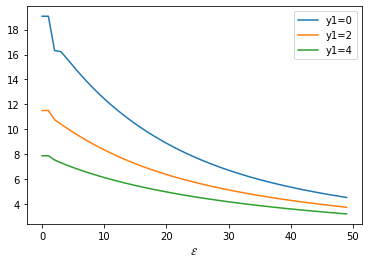

In [115]:
plt.plot(model_res['e_tilde'][0, :], label='y1=0')
plt.plot(model_res['e_tilde'][25, :], label='y1=2')
plt.plot(model_res['e_tilde'][-1, :], label='y1=4')
plt.xlabel(r'$\mathcal{E}$')
plt.legend()

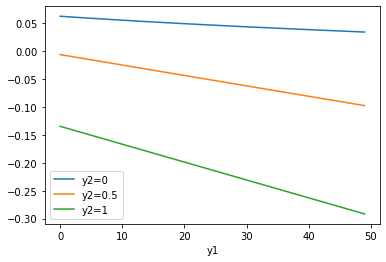

In [113]:
plt.plot(model_res['v0'][:, 0], label='y2=0')
plt.plot(model_res['v0'][:, 25], label='y2=0.5')
plt.plot(model_res['v0'][:, -1], label='y2=1')
plt.xlabel('y1')
plt.legend()

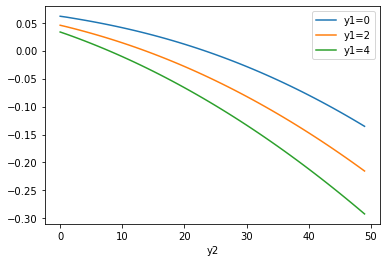

In [153]:
plt.plot(model_res['v0'][0, :], label='y1=0')
plt.plot(model_res['v0'][25, :], label='y1=2')
plt.plot(model_res['v0'][-1, :], label='y1=4')
plt.xlabel('y2')
plt.legend()